# 1_business_data_understanding_suto

In [25]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import mean_absolute_error, mean_squared_error

path_data = "../data/raw/"
path_interim_data = "../data/interim/"

# Parâmetros estéticos dos gráficos:
set_palette = "Paired"
axes_style = "ticks"

linha = 50*"-"

In [4]:
df_data = pd.read_csv(path_data+"auto-mpg.csv")

print(f"Dimensões do dataset: {df_data.shape}")

df_data.head()

Dimensões do dataset: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Entendendo cada fator

Vamos pegar cada fator e simplesmente plotar para verificar se "faz sentido".

### Limpeza de dados

Quando fomos verificar a "natureza"/tipo de cada fator, vimos que o o fator **horsepower** estava como *object*. Analisando um pouco melhor, vimos que havia a string *"?"* em 6 registros/observações. Para facilitar, seguiremos com a substituição das strings *"?"* pela média da amostra que temos. Posteriormente, usaremos técnicas melhores, como por exemplo **K-vizinhos mais próximos**.

In [5]:
df_data.loc[~df_data["horsepower"].str.isnumeric()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


In [6]:
df_data_limpo = df_data.copy()

media_horsepower = df_data_limpo.loc[df_data["horsepower"].str.isnumeric(), "horsepower"]
media_horsepower = media_horsepower.astype("float64")
media_horsepower = int(media_horsepower.mean())

print(f"""A média dos registros/observações horsepower exluindo os registros com "?" é {media_horsepower}.""")

# Substituição dos valores "?" pela média:
df_data_limpo["horsepower"].replace(to_replace="?", value=media_horsepower, inplace=True)
df_data_limpo["horsepower"] = df_data_limpo["horsepower"].astype("float64")

A média dos registros/observações horsepower exluindo os registros com "?" é 104.


### Verificando a distribuição dos fatores contínuos:
- **Resposta:** mpg
- **Fatores**:
 - displacement
 - horsepower
 - weight
 - acceleration

In [7]:
lst_continuas = df_data_limpo.select_dtypes(include=[float, "float32", "float64"]).columns
lst_continuas = sorted(lst_continuas)
lst_continuas

['acceleration', 'displacement', 'horsepower', 'mpg']

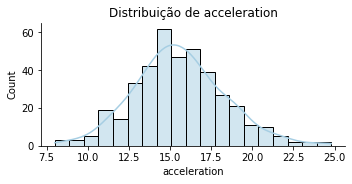

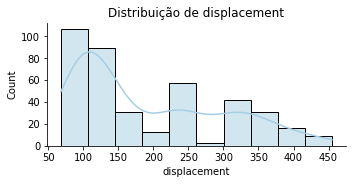

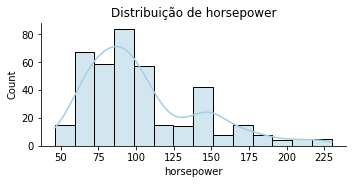

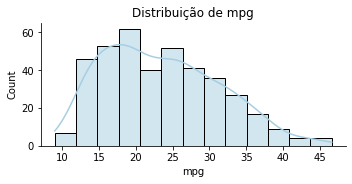

In [8]:
sns.set_palette(set_palette)
sns.axes_style(axes_style)

for i, feature in enumerate(df_data_limpo[lst_continuas].columns):
#     x = pd.Series(df_data_limpo.loc[:, feature])
    ax = sns.displot(df_data_limpo.loc[:, feature], kde=True)
    ax.set(title="Distribuição de "+feature)
    ax.fig.set_size_inches(5,2)

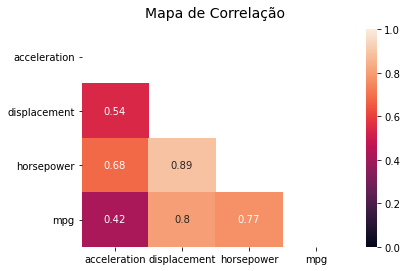

In [9]:
# Pegando somente os atributos/fatores/variáveis de entrada contínuas.
lst_continuas = df_data_limpo.select_dtypes(include=["float", "float32", "float64"]).columns

# Calculando a matriz de correlação entre os fatores, incluindo a resposta ("mpg").
correlation_matrix = abs(df_data_limpo[sorted(lst_continuas)].corr())

mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

sns.set_palette(set_palette)
sns.axes_style(axes_style)

ax = sns.heatmap(correlation_matrix, vmin=0, vmax=1, mask=mask,annot=True)
ax.set_title('Mapa de Correlação', fontdict={'fontsize':14}, pad=12);

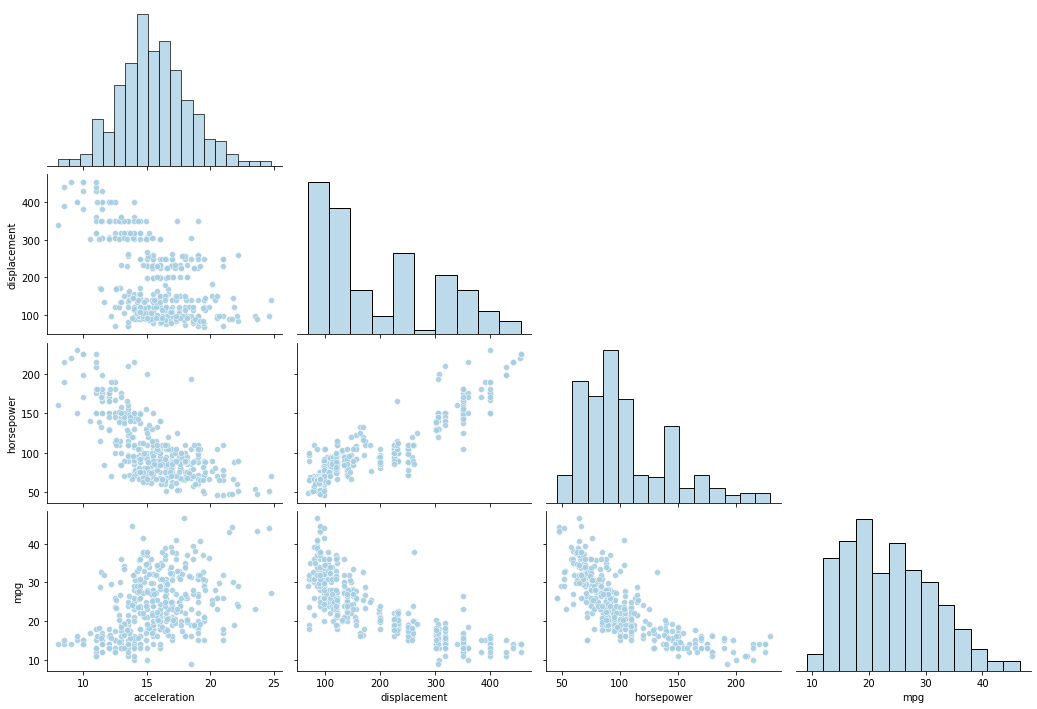

In [10]:
sns.set_palette(set_palette)
sns.axes_style(axes_style)

ax = sns.pairplot(df_data_limpo[sorted(lst_continuas)], plot_kws={'alpha':0.9}, corner=True);

ax.fig.set_size_inches(15,10)

### Verificando a distribuição dos fatores discretos:
- **Fatores**:
 - 'cylinders',
 - 'model year',
 - 'origin',
 - 'car name'

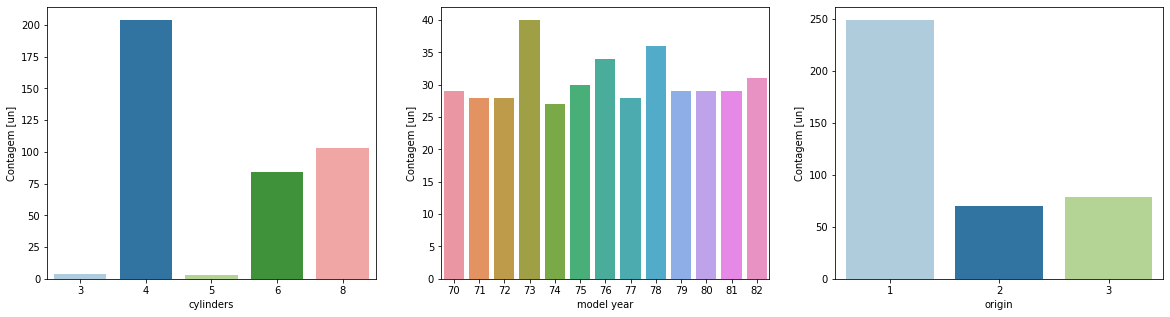

In [11]:
lst_categoricos = ['cylinders', 'model year', 'origin']

sns.set_palette(set_palette)
sns.axes_style(axes_style)

fig, axs = plt.subplots(ncols=3, figsize=(20,5))

for i, feature in enumerate(df_data_limpo[lst_categoricos].columns):
    ax = sns.countplot(x=feature, data=df_data_limpo, ax=axs[i])
    ax.set(ylabel="Contagem [un]")

#### Investigando a variável 'car name'

In [12]:
df_data_limpo["car name"].value_counts()

ford pinto                 6
ford maverick              5
toyota corolla             5
amc matador                5
chevrolet chevette         4
                          ..
peugeot 504 (sw)           1
buick opel isuzu deluxe    1
amc concord d/l            1
plymouth fury              1
mercedes benz 300d         1
Name: car name, Length: 305, dtype: int64

In [13]:
df_repeated_cars = df_data_limpo["car name"].value_counts()[df_data_limpo["car name"].value_counts()>1]

print(f"""Existem {len(df_repeated_cars.index)} 'car names' que se repetem.
Essas repetições correspondem a {df_repeated_cars.sum()} registros no df_data ({round(100*df_repeated_cars.sum()/len(df_data),1)}% do total).""")
print(linha)

df_data_repetead = df_data_limpo.loc[df_data_limpo["car name"].isin(set(df_repeated_cars.index)), :].copy()
df_data_repetead.sort_values(by=["car name", "model year"], inplace=True)
df_data_repetead

Existem 56 'car names' que se repetem.
Essas repetições correspondem a 149 registros no df_data (37.4% do total).
--------------------------------------------------


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
257,19.4,6,232.0,90.0,3210,17.2,78,1,amc concord
315,24.3,4,151.0,90.0,3003,20.1,80,1,amc concord
24,21.0,6,199.0,90.0,2648,15.0,70,1,amc gremlin
33,19.0,6,232.0,100.0,2634,13.0,71,1,amc gremlin
107,18.0,6,232.0,100.0,2789,15.0,73,1,amc gremlin
...,...,...,...,...,...,...,...,...,...
240,30.5,4,97.0,78.0,2190,14.1,77,2,volkswagen dasher
175,29.0,4,90.0,70.0,1937,14.0,75,2,volkswagen rabbit
203,29.5,4,97.0,71.0,1825,12.2,76,2,volkswagen rabbit
197,29.0,4,90.0,70.0,1937,14.2,76,2,vw rabbit


Porém, quando agrupamos em  'car names' e 'model year', ocorrem somente duas repetições:
- ford pinto de 75
- plymouth reliant de 81

In [14]:
repeticoes = (df_data_limpo.groupby(["car name", "model year"]).agg({"mpg":"count"}).rename(columns={"mpg":"contagem"}).reset_index())
repeticoes.loc[repeticoes.sort_values(by="contagem", ascending=False)["contagem"]>1]

,car name,model year,contagem
211,ford pinto,75,2
300,plymouth reliant,81,2


In [15]:
df_data_limpo.loc[((df_data_limpo["car name"]=="ford pinto") &
                   (df_data_limpo["model year"]==75))|
                  ((df_data_limpo["car name"]=="plymouth reliant") &
                   (df_data_limpo["model year"]==81)), :]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
168,23.0,4,140.0,83.0,2639,17.0,75,1,ford pinto
174,18.0,6,171.0,97.0,2984,14.5,75,1,ford pinto
338,27.2,4,135.0,84.0,2490,15.7,81,1,plymouth reliant
342,30.0,4,135.0,84.0,2385,12.9,81,1,plymouth reliant


A tabela acima evidencia que apesar de termos detectado que haviam muitos 'car names' repetidos, eles não representam o mesmo carro. Por mesmo carro, entendemos que será o registro que possui 'car name', 'model year' e 'cylinders' com os mesmos valores. Portanto, temos apenas uma repetição: **plymouth reliant de 81 com 4 cilindros**.

Para tratar essa repetição, pegaremos as médias de cada atributo desse registro repetido.

In [16]:
df_data_without_repetition = (df_data_limpo.groupby(["car name", "model year", "cylinders"])
                              .mean().reset_index())

print(f"Dimensões do dataset: {df_data_without_repetition.shape}")

df_data_without_repetition.loc[((df_data_without_repetition["car name"]=="ford pinto") &
                                (df_data_without_repetition["model year"]==75))|
                               ((df_data_without_repetition["car name"]=="plymouth reliant") &
                                (df_data_without_repetition["model year"]==81)), :]

Dimensões do dataset: (397, 9)


,car name,model year,cylinders,mpg,displacement,horsepower,weight,acceleration,origin
211,ford pinto,75,4,23.0,140.0,83.0,2639.0,17.0,1.0
212,ford pinto,75,6,18.0,171.0,97.0,2984.0,14.5,1.0
301,plymouth reliant,81,4,28.6,135.0,84.0,2437.5,14.3,1.0


### Analisando o impacto ("jeitão") de cada variável categórica com a reposta ("mpg")

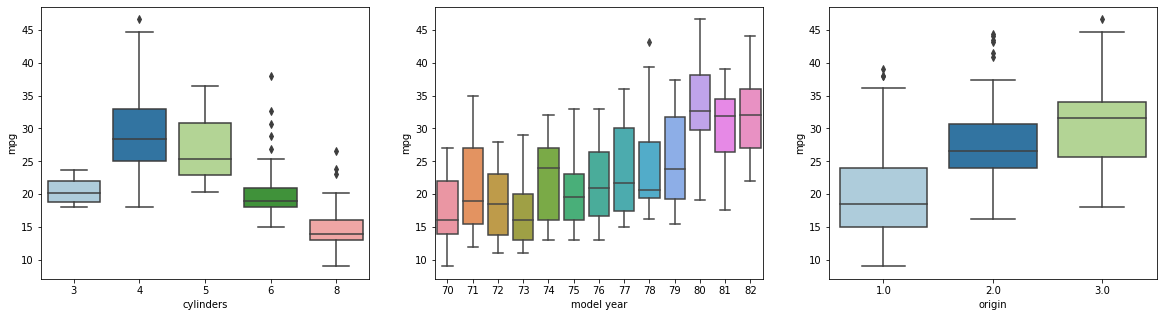

In [17]:
sns.set_palette(set_palette)
sns.axes_style(axes_style)

fig, axs = plt.subplots(ncols=3, figsize=(20,5))

for i, feature in enumerate(df_data_without_repetition[lst_categoricos].columns):
    sns.boxplot(x=feature, y="mpg", data=df_data_without_repetition, ax=axs[i])

### Criando um novo fator/variável de entrada

O fator 'car name' possui a marca do carro. Será que essa seria uma variável importante?

In [18]:
def get_car_brand(string):
    """
    Essa função, extrai a marca do carro. Ela extrai os caracteres anteriores ao primeiro espaço.
    Inputs: string
    Output: slice de string
    """
    index = string.find(" ")
    return string[:index]

In [19]:
df_data_without_repetition["car brand"] = df_data_without_repetition["car name"].apply(get_car_brand)

# Arrumando a ordem dos fatores e reposta:
df_data_without_repetition = df_data_without_repetition[['car name', 'car brand', 'model year', 'cylinders', 'displacement',
                                                         'horsepower', 'weight', 'acceleration', 'origin', 'mpg']]

df_data_without_repetition.head()

,car name,car brand,model year,cylinders,displacement,horsepower,weight,acceleration,origin,mpg
0,amc ambassador brougham,amc,73,8,360.0,175.0,3821.0,11.0,1.0,13.0
1,amc ambassador dpl,amc,70,8,390.0,190.0,3850.0,8.5,1.0,15.0
2,amc ambassador sst,amc,72,8,304.0,150.0,3672.0,11.5,1.0,17.0
3,amc concord,amc,78,6,232.0,90.0,3210.0,17.2,1.0,19.4
4,amc concord,amc,80,4,151.0,90.0,3003.0,20.1,1.0,24.3


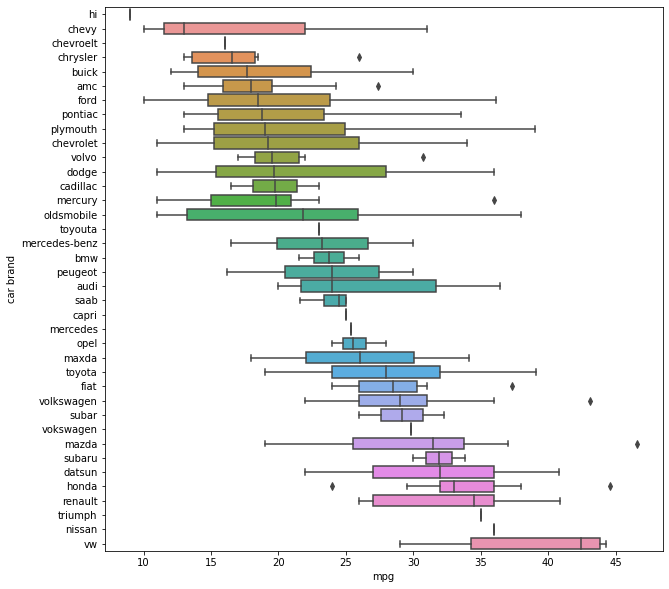

In [20]:
brand_mpg_order = (df_data_without_repetition.groupby("car brand").agg({"mpg": "median"}).rename(columns={"mpg": "mediana de mpg"}).reset_index())
brand_mpg_order.sort_values(by="mediana de mpg", inplace=True)

plt.figure(figsize=(10,10))
ax = sns.boxplot(y="car brand", x="mpg", data=df_data_without_repetition, order=brand_mpg_order["car brand"])

O gráfico acima evidenciou "*typos*" nas marcas. Por exemplo:
- **chevrolet** aparece também como **chevroelt**
- **mazda** aparece também como **maxda**
- **mercedes-benz** aparece também como **mercedes**
- **subaru** aparece também como **subar**
- **toyota** aparece também como **toyouta**
- **volkswagen** aparece também como **vokswagen** e **vw**

Como são poucas substituições, faremos manualmente. No entanto uma estratégia usando Regex seja uma alternativa melhor quando lidamos com uma quantidade de dados maior.

In [21]:
df_data_without_repetition.replace({"chevroelt":"chevrolet", "maxda":"mazda", "mercedes-benz":"mercedes",
                                    "subar":"subaru", "toyouta":"toyota", "vokswagen":"volkswagen", "vw":"volkswagen"}, inplace=True)

df_data_without_repetition.loc[df_data_without_repetition["car brand"].str.contains("toy")].head(3)

,car name,car brand,model year,cylinders,displacement,horsepower,weight,acceleration,origin,mpg
342,toyota carina,toyota,73,4,97.0,88.0,2279.0,19.0,3.0,20.0
343,toyota celica gt,toyota,82,4,144.0,96.0,2665.0,13.9,3.0,32.0
344,toyota celica gt liftback,toyota,78,4,134.0,95.0,2515.0,14.8,3.0,21.1


Refazendo o boxplot das marcas por mpg:

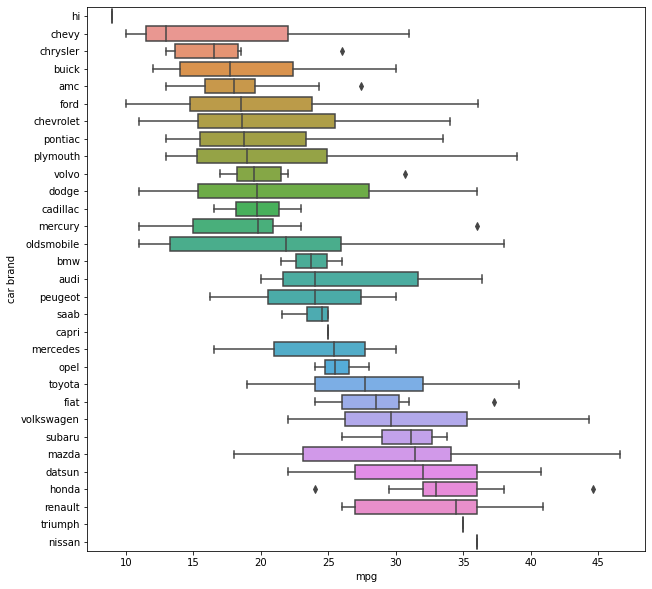

In [22]:
brand_mpg_order = (df_data_without_repetition.groupby("car brand").agg({"mpg": "median"}).rename(columns={"mpg": "mediana de mpg"}).reset_index())
brand_mpg_order.sort_values(by="mediana de mpg", inplace=True)

plt.figure(figsize=(10,10))
ax = sns.boxplot(y="car brand", x="mpg", data=df_data_without_repetition, order=brand_mpg_order["car brand"])

In [23]:
print(f"""Por fim, ficamos com um dataset com:
 - {df_data_without_repetition.shape[0]} registros; e
 - {df_data_without_repetition.shape[1]-1} atributos.
 
 Ou seja, reduzimos um registro e aumentamos um atributo em relação ao original.""")

df_data_without_repetition.head()

Por fim, ficamos com um dataset com:
 - 397 registros; e
 - 9 atributos.
 
 Ou seja, reduzimos um registro e aumentamos um atributo em relação ao original.


,car name,car brand,model year,cylinders,displacement,horsepower,weight,acceleration,origin,mpg
0,amc ambassador brougham,amc,73,8,360.0,175.0,3821.0,11.0,1.0,13.0
1,amc ambassador dpl,amc,70,8,390.0,190.0,3850.0,8.5,1.0,15.0
2,amc ambassador sst,amc,72,8,304.0,150.0,3672.0,11.5,1.0,17.0
3,amc concord,amc,78,6,232.0,90.0,3210.0,17.2,1.0,19.4
4,amc concord,amc,80,4,151.0,90.0,3003.0,20.1,1.0,24.3


#### Extraindo a base para a próxima etapa

In [27]:
df_data_without_repetition.to_parquet(path_interim_data+"df_data_step_1_output.pqt")

## Próximo passo:

- Em [2_data_preparation_suto.ipynb](./2_data_preparation_suto.ipynb):
 - transformaremos os dados categóricos em numéricos para serem consumidos pelo modelo.